<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%2018/VED_EELS_particles_v2_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

May 13, 2020

Sergei V. Kalinin

Here, based on the EELS data on particles, we aim to implement the im2spec and spec2im translation. This is an intermediate step between GP and DNN analytics in spectral domain, and predictability of the EELS spectra to be implemented via descriptor vector.




# Predictability of localized plasmonic responses in nanoparticle assemblies
2.21.20

Notebook created by Kevin Roccapriore with Jordan Hachtel & Maxim Ziatdinov.

This is a collection of analytical tools designed to compress the features (both in space and energy) of plasmon resonances into a latent feature space, representing the most significant latent variables. Once the latent space can be extracted, we use autoencoder scheme to learn and hence predict the EEL spectra given a geometric arrangement of particles (*im2spec* network) and vice versa (*spec2im* network)

_________

Published in Small: https://onlinelibrary.wiley.com/doi/full/10.1002/smll.202100181

arXiv: https://arxiv.org/abs/2009.09005

_________

The following data was collected by Kevin Roccapriore and Jordan Hachtel using the monochromated abberation corrected scanning transmission electron microscope (MACSTEM)

In [1]:
#@title Dependencies

import numpy as np
import pandas as pd
import json
from pylab import cm
from scipy import interpolate
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy import ndimage
import operator
from scipy import signal
import matplotlib
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits import mplot3d

In [2]:
#@title Function definitions
def TruncateColormap(cmap = 'jet', lowerlim = 0, upperlim = 1, N=100):
    '''Cuts the upper/lower bound limits of a previously specified color map.
    For example, user wishes to display half the jet cmap- from red to green,
    instead of from red to blue.
    Inputs:
        cmap: the color map to truncate
        lowerlim and upperlim: from scale from 0 to 1. lowerlim=0 and upperlim=1
        would return the identical cmap
        N number of steps
    '''
    gotcmap = plt.get_cmap(cmap)
    truncatedcolormap = LinearSegmentedColormap.from_list('list', gotcmap(np.linspace(lowerlim, upperlim, 100)),N=100)
    return truncatedcolormap

def OrganizeInput(numpy):
    SIraw = np.load(numpy)
    XY = SIraw.shape[:2]
    SIj = json.load(open(numpy[:-3]+'json','r'))
    disp = SIj['spatial_calibrations'][2]['scale']
    SIraw_flat=SIraw.reshape((np.prod(XY),SIraw.shape[2]))
    return SIraw, XY, disp, SIraw_flat

def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def BlurSpectra_single(SIraw, sigma = 10):
    SIraw_blur_single = ndimage.filters.gaussian_filter(SIraw, sigma = sigma)
    return SIraw_blur_single

def BlurSpectra(SIraw, sigma = 10):
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = sigma)
    return SIraw_blur

def BlurSpectra_flat(SI, sigma = 10):
    SI_blur = np.zeros_like(SI)
    for ii in range(SI_blur.shape[0]):
        SI_blur[ii] = ndimage.filters.gaussian_filter(SI[i,:], sigma = sigma)
    return SI_blur

def CorrectNeg(SIraw, Blur = 10, Neg = -20, Pixrange = 250):
    """
    Args:
       SI = Accepts any 3-dim SI as the operated-on SI, normally raw
       Blur =   gaussian blur sigma value. Should be set 10-30
                range to avoid false peaks due to noise
       Neg =    value which is considered to be negative.
                Generally shouldn't be set to exactly 0 (or very close,
                like -1), due to noise effects
                **this also prevents spectra which are not negative at
                all from being artificially offset**
       Pixrange = number of pixels to average (centered around most
                negative pixel located after blurring) over for sub-
                tracting from raw data
    Returns:
       - Original SI with offset
       - Blurred SI with offset
       - Plot of original + blurred offset
    """
    # blurs each pixels' spectrum
    SIraw_blur = np.zeros((SIraw.shape[0],SIraw.shape[1],SIraw.shape[2]))
    for i in range(SIraw.shape[0]):
        for j in range(SIraw.shape[1]):
            SIraw_blur[i,j] = ndimage.filters.gaussian_filter(SIraw[i,j,:], sigma = Blur)

    # local min peak search:
    # performs scipy findpeaks function (inverts signal to find MIN), then picks out most negative
    # again, should be OK due to the blurring previously
    # Derp, I think this could've been done much easier with np.min() and np.argmin()...
    # Actually maybe not, because I set a height parameter with findpeaks.

    MN = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    posmaxpixel = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.amax(SIraw[i,j])<5000:
                MN[i,j] = np.nan
            else:
                posmaxpixel[i,j]= np.argmax(SIraw_blur[i,j,:])

                peaks,props = signal.find_peaks(-1*SIraw_blur[i,j,int(posmaxpixel[i,j]):],height = -20)
                keys = peaks.tolist()
                values = props['peak_heights'].tolist()
                peakdict = dict(zip(keys, values))
                sorted_peakdict = sorted(peakdict.items(), key=operator.itemgetter(1))
                mostneg = np.array(sorted_peakdict[-1:])
                mostnegT = mostneg.T
                try:
                    MN[i,j] = posmaxpixel[i,j]+mostnegT[0][0] # this is the most negative pixel, value that we need
                except IndexError:
                    MN[i,j] = np.nan # if sample TOO THICK, spectrum is noise, so will produce index error;
                                     # this just gives that the bird by setting to NaN.



    SInc =  np.zeros_like(SIraw)
    SInegmean = np.zeros((SIraw.shape[0],SIraw.shape[1]))
    for i in range(SIraw_blur.shape[0]):
         for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:     # handling if sample too thick
                SInc[i,j] = SIraw[i,j]
            elif np.isnan(MN[i,j]) == False:
                SInegmean[i,j] = np.mean(SIraw_blur[i,j,int(MN[i,j]-Pixrange/2):int(MN[i,j]+Pixrange/2)])
                SInc[i,j] = SIraw[i,j] - SInegmean[i,j]



    # for plotting (finding scatter XY coordinates)
    x_pos, y_pos = np.zeros_like(MN), np.zeros_like(MN)
    for i in range(SIraw_blur.shape[0]):
        for j in range(SIraw_blur.shape[1]):
            if np.isnan(MN[i,j]) == True:
                x_pos[i,j] = 0
                y_pos[i,j] = 0
            else:
                x_pos[i,j] = int(MN[i,j])
                y_pos[i,j] = SIraw_blur[i,j,int(x_pos[i,j])]

    i,j = np.random.randint(SIraw.shape[0]), np.random.randint(SIraw.shape[1])

    fig = plt.figure(figsize=(16,4))
    gs = gridspec.GridSpec(1,2)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    ax1.plot(SIraw_blur[i,j,:])
    ax1.plot(SIraw[i,j], alpha = 0.5)
    ax1.set_ylim(-100,1000)
    ax1.axhline(0,color='k',ls='--',lw=1.5)

    if x_pos[i,j] == 0:
        ax1.annotate('No offset performed: \nCould not find negative enough value', xy = (0.5,0.7), xycoords = 'axes fraction')
    else:
        ax1.scatter(x_pos[i,j], y_pos[i,j], color = 'r')
        patch1 = patches.Rectangle((x_pos[i,j]-Pixrange/2, y_pos[i,j]-30), Pixrange, 60, linewidth = 1, edgecolor = 'red', facecolor = 'red', fill = False)
        ax1.add_patch(patch1)


    ax2.plot(SInc[i,j])
    ax2.set_ylim(-100,1000)
    ax2.axhline(0,color='k',ls='--',lw=1.5);

    # r'$\bf{fixed \ data}$

    ax1.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Raw SI, blurred SI, region of averaging'.format(i,j))
    ax2.set_title(r'$\bf{XY} = $' + r'$\bf[{},{}]$: Corrected SI'.format(i,j))

    return SInc

def CalibrateEnergyAxis(SI,disp,style='fwhm',subfitwidth=8):
    Einit=np.arange(0,SI.shape[2])*disp
    if style=='pixel': ZLPC=np.array([[Einit[np.argmax(s)] for s in row] for row in SI])
    if style=='fwhm':
        lh,uh=[],[]
        avspec=np.average(SI,axis=(0,1))
        for row in SI:
            lh.append([]);uh.append([])
            for s in row:
                if np.amax(s)<1000: # This line is for thick samples when ZLP drops to noise levels
                    s=avspec
                lh[-1].append(Einit[np.argmin(np.abs(s[:np.argmax(s)]/np.amax(s)-0.5))])
                uh[-1].append(Einit[np.argmin(np.abs(s[np.argmax(s):]/np.amax(s)-0.5))+np.argmax(s)])
        lh=np.asarray(lh)
        uh=np.asarray(uh)
        ZLPC=np.average([uh,lh],axis=0)
    if style=='subpixel':
        def gauss(x,a,x0,s): return a*np.exp(-(x-x0)**2/s**2)
        from scipy.optimize import curve_fit
        ZLPC=np.array([[curve_fit(gauss,Einit[np.argmax(s)-W:np.argmax(s)+W],
                               s[np.argmax(s)-W:np.argmax(s)+W]/np.amax(s))[0][1] for s in row] for row in SI])
    return np.array([[Einit-c for c in row] for row in ZLPC])

def CalibrateSI(EAx,SI,N=5000):
    m,M = np.amax(np.amin(EAx,axis=(2))), np.amin(np.amax(EAx,axis=(2)))
    Eout=np.linspace(m,M,N)[1:]
    Eout=np.linspace(m,M,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(EAx,SI)])
    return Eout,SIout

def FitPowerlaw(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    #e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))

    ax=fig.add_subplot(131)

    plt.plot(E,S,color='k',label='Data')
    plt.plot(E[ist:ien],S[ist:ien],marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[ist+1],E[ien-1],1000)
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    plt.ylim(0,0.002)
    r,A0=np.polyfit(elog,slog,1)

    ax=fig.add_subplot(132)

    plt.plot(E[ist:],S[ist:],color='k',label='Data')
    plt.plot(E[ist:],np.exp(A0)*E[ist:]**(r),'b',lw=3,label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)

    ax=fig.add_subplot(133)

    plt.axhline(0,color='k')
    plt.plot(E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)
    plt.ylim(-0.0001,0.001)
    return fite,0.#,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d)

def FitPowerlaw2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    fig=plt.figure(figsize=(20,3))

    ax=fig.add_subplot(131)

    plt.plot(E*1000,S,color='k',label='Data')
    plt.plot(e*1000,s,marker='o',ms=7,markerfacecolor='none',markeredgecolor='r',lw=0,label='Fit Region')
    plt.legend(frameon=False,fontsize=13)
    fite=np.linspace(E[is1+1],E[ie2-1],300)
    f=interpolate.interp1d(E[is1:ie2],S[is1:ie2],kind='linear')
    nozeros=s[np.where(s>0)]
    nozeroe=e[np.where(s>0)]
    elog=np.log(nozeroe)
    slog=np.log(nozeros)
    plt.ylim(0,0.02)
    r,A0=np.polyfit(elog,slog,1)

    ax=fig.add_subplot(132)

    plt.plot(E[is1:]*1000,S[is1:],color='k',label='Data')
    plt.plot(E[is1:]*1000,np.exp(A0)*E[is1:]**(r),'b',label='Power Law Fit')
    plt.tick_params(labelsize=16)
    plt.legend(frameon=False,fontsize=13)

    ax=fig.add_subplot(133)

   # plt.plot(fite,f(fite)-np.exp(a*fite**3+b*fite**2+c*fite+d),color='r',label='Exponential Subtraction')
    plt.plot(E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r),color='b',label='Powerlaw Subtraction')
    plt.tick_params(labelsize=16)
    ax.set_xlabel(r'Energy Loss ($eV$)',fontsize=16)
    plt.subplots_adjust(top=1,bottom=0.06,right=1,left=0.15)
    plt.axhline(0,color='k')
    plt.legend(frameon=False,fontsize=10,labelspacing=0.3,handlelength=1,handletextpad=0.2)

    plt.ylim(-0.0001,0.001)

    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)


## background subtraction using either 1 region or 2 regions:

def RemoveBackgroundSI(E,S,fst,fen):
    ist=np.argmin(np.abs(E-fst));ien=np.argmin(np.abs(E-fen))
    f=interpolate.interp1d(E[ist:ien],S[ist:ien],kind='linear')
    elog=np.log(E[ist:ien][np.where(S[ist:ien]>0)])
    slog=np.log(S[ist:ien][np.where(S[ist:ien]>0)])
    if len(np.where(S[ist:ien]>0)[0]) == 0.:
        plt.plot(E[ist:],S[ist:])
        return E[ist:],np.zeros(E[ist:].shape)
    r,A0=np.polyfit(elog,slog,1)
    return E[ist:],S[ist:]-np.exp(A0)*E[ist:]**(r),

def RemoveBackgroundSI2R(E,S,fs1,fe1,fs2,fe2):
    is1=np.argmin(np.abs(E-fs1));ie1=np.argmin(np.abs(E-fe1))
    is2=np.argmin(np.abs(E-fs2));ie2=np.argmin(np.abs(E-fe2))
    e,s=np.append(E[is1:ie1],E[is2:ie2]),np.append(S[is1:ie1],S[is2:ie2])
    elog=np.log(e[np.where(s>0)])
    slog=np.log(s[np.where(s>0)])
    r,A0=np.polyfit(elog,slog,1)
    return E[is1:],S[is1:]-np.exp(A0)*E[is1:]**(r)

from matplotlib.colors import LinearSegmentedColormap

data1 = np.linspace(0, 1, 2500).reshape((50, 50))

bPw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (150./255,50/255., 1.),(1,1,1)], N=100)
bOw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (1,120./255, 0),(1,1,1)], N=100)
bGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (50./255,220./255, 50./255),(1,1,1)], N=100)
bBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (10./255,175/255., 1.),(1,1,1)], N=100)
bDBw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (0/255,0./255, 255/255),(1,1,1)], N=100)
bRw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (200./255,20/255., 20/225.),(1,1,1)], N=100)
bPiw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (225./255,105/255., 180/225.),(1,1,1)], N=100)
bBrw= LinearSegmentedColormap.from_list('list', [(0, 0, 0), (210./255,180/255., 140/225.),(1,1,1)], N=100)
bYw= LinearSegmentedColormap.from_list('list', [(0, 0, 0), (200./255,200/255., 0/225.),(1,1,1)], N=100)
bLGw = LinearSegmentedColormap.from_list('list', [(0, 0, 0), (50./255, 200/255, 200/255),(1,1,1)], N=100)

cmaps = [bPw,bOw,bGw,bBw,bDBw,bRw,bPiw,bBrw,bYw,bLGw]

In [3]:
#@title extra functions for encoder-decoder

def get_coord_grid(imgdata: np.ndarray, step: int,
                   return_dict: bool = True
                   ):
    """
    Generate a square coordinate grid for every image in a stack. Returns coordinates
    in a dictionary format (same format as generated by atomnet.predictor)
    that can be used as an input for utility functions extracting subimages
    and atomstat.imlocal class

    Args:
        imgdata (numpy array): 2D or 3D numpy array
        step (int): distance between grid points
        return_dict (bool): returns coordiantes as a dictionary (same format as atomnet.predictor)

    Returns:
        Dictionary or numpy array with coordinates
    """
    if np.ndim(imgdata) == 2:
        imgdata = np.expand_dims(imgdata, axis=0)
    coord = []
    for i in range(0, imgdata.shape[1], step):
        for j in range(0, imgdata.shape[2], step):
            coord.append(np.array([i, j]))
    coord = np.array(coord)
    if return_dict:
        coord = np.concatenate((coord, np.zeros((coord.shape[0], 1))), axis=-1)
        coordinates_dict = {i: coord for i in range(imgdata.shape[0])}
        return coordinates_dict
    coordinates = [coord for _ in range(imgdata.shape[0])]
    return np.concatenate(coordinates, axis=0)

def extract_subimages(imgdata, coordinates, window_size, coord_class = 0):
    """
    Extracts subimages centered at certain atom class/type
    (usually from a neural network output)

    Args:
        imgdata (numpy array):
            4D stack of images (n, height, width, channel).
            It is also possible to pass a single 2D image.
        coordinates (dict or N x 2 numpy arry): Prediction from atomnet.locator
            (can be from other source but must be in the same format)
            Each element is a :math:`N \\times 3` numpy array,
            where *N* is a number of detected atoms/defects,
            the first 2 columns are *xy* coordinates
            and the third columns is class (starts with 0).
            It is also possible to pass N x 2 numpy array if the corresponding
            imgdata is a single 2D image.
        window_size (int):
            Side of the square for subimage cropping
        coord_class (int):
            Class of atoms/defects around around which the subimages
            will be cropped (3rd column in the atomnet.locator output)

    Returns:
        3-element tuple containing

        - stack of subimages,
        - (x, y) coordinates of their centers,
        - frame number associated with each subimage
    """
    if isinstance(coordinates, np.ndarray):
        coordinates = np.concatenate((
            coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1)
        coordinates = {0: coordinates}
    if np.ndim(imgdata) == 2:
        imgdata = imgdata[None, ..., None]
    subimages_all, com_all, frames_all = [], [], []
    for i, (img, coord) in enumerate(
            zip(imgdata, coordinates.values())):
        coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
        stack_i, com_i = get_imgstack(img, coord_i, window_size)
        if stack_i is None:
            continue
        subimages_all.append(stack_i)
        com_all.append(com_i)
        frames_all.append(np.ones(len(com_i), int) * i)
    if len(subimages_all) > 0:
        subimages_all = np.concatenate(subimages_all, axis=0)
        com_all = np.concatenate(com_all, axis=0)
        frames_all = np.concatenate(frames_all, axis=0)

    return subimages_all, com_all, frames_all

def get_imgstack(imgdata: np.ndarray,
                 coord: np.ndarray,
                 r: int):
    """
    Extracts subimages centered at specified coordinates
    for a single image

    Args:
        imgdata (3D numpy array):
            Prediction of a neural network with dimensions
            :math:`height \\times width \\times n channels`
        coord (N x 2 numpy array):
            (x, y) coordinates
        r (int):
            Window size

    Returns:
        2-element tuple containing

        - Stack of subimages
        - (x, y) coordinates of their centers
    """
    img_cr_all = []
    com = []
    for c in coord:
        cx = int(np.around(c[0]))
        cy = int(np.around(c[1]))
        if r % 2 != 0:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2+1,
                        cy-r//2:cy+r//2+1])
        else:
            img_cr = np.copy(
                imgdata[cx-r//2:cx+r//2,
                        cy-r//2:cy+r//2])
        if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
            img_cr_all.append(img_cr[None, ...])
            com.append(c[None, ...])
    if len(img_cr_all) == 0:
        return None, None
    img_cr_all = np.concatenate(img_cr_all, axis=0)
    com = np.concatenate(com, axis=0)
    return img_cr_all, com

def extract_patches_and_spectra(hdata: np.ndarray, *args: np.ndarray,
                                coordinates,
                                window_size,
                                avg_pool,
                                **kwargs):
    """
    Extracts image patches and associated spectra
    (corresponding to patch centers) from hyperspectral dataset

    Args:
        hdata:
            3D or 4D hyperspectral data
        *args:
            2D image for patch extraction. If not provided, then
            patches will be extracted from hyperspectral data
            averaged over a specified band (range of "slices")
        coordinates:
            2D numpy array with xy coordinates
        window_size:
            Image patch size
        avg_pool:
            Kernel size and stride for average pooling in spectral dimension(s)
        **band:
            Range of slices in hyperspectral data to average over
            for producing a 2D image if the latter is not provided as a separate
            argument. For 3D data, it can be integer (use a single slice)
            or a 2-element list. For 4D data, it can be integer or a 4-element list.

        Returns:
            3-element tuple with image patches, associated spectra and coordinates
    """
    F = torch.nn.functional
    if hdata.ndim not in (3, 4):
        raise ValueError("Hyperspectral data must 3D or 4D")
    if len(args) > 0:
        img = args[0]
        if img.ndim != 2:
            raise ValueError("Image data must be 2D")
    else:
        band = kwargs.get("band", 0)
        if hdata.ndim == 3:
            if isinstance(band, int):
                band = [band, band+1]
            img = hdata[..., band[0]:band[1]].mean(-1)
        else:
            if isinstance(band, int):
                band = [band, band+1, band, band+1]
            elif isinstance(band, list) and len(band) == 2:
                band = [*band, *band]
            img = hdata[..., band[0]:band[1], band[2]:band[3]].mean((-2, -1))
    patches, coords, _ = extract_subimages(img, coordinates, window_size)
    patches = patches.squeeze()
    spectra = []
    for c in coords:
        spectra.append(hdata[int(c[0]), int(c[1])])
    avg_pool = 2*[avg_pool] if (isinstance(avg_pool, int) & hdata.ndim == 4) else avg_pool
    torch_pool = F.avg_pool1d if hdata.ndim == 3 else F.avg_pool2d
    spectra = torch.tensor(spectra).unsqueeze(1)
    spectra = torch_pool(spectra, avg_pool, avg_pool).squeeze().numpy()
    return patches, spectra, coords

def interpolate_spectra(spectra, N=1024):

    if spectra.ndim not in (1,2):
        raise NotImplementedError("spectra needs to be a stack of spectra or a single spectrum")

    if spectra.ndim == 2:
        x_old = np.linspace(0, len(spectra[0]), len(spectra[0]))
        x_new = np.linspace(0, len(spectra[0]), N)
        new_specs = np.asarray([interpolate.interp1d(x_old, spec)(x_new) for spec in spectra])

    else:
        x_old = np.linspace(0, len(spectra), len(spectra))
        x_new = np.linspace(0, len(spectra), N)
        new_specs = interpolate.interp1d(x_old, spectra)(x_new)

    return new_specs


def backproject_features(latent_features, n, m, features):
    latent_features, _ = ved.encode(features)
    latent_features = latent_features.cpu()

    if latent_features.shape[-1] != 2:
        raise ValueError("Your latent vector last dimension must be equal to 2")

    xmin = latent_features[:, 0].min()
    ymin = latent_features[:, 1].min()
    xmax = latent_features[:, 0].max()
    ymax = latent_features[:, 1].max()

    # n = 16
    window_size1 = n
    window_size2 = m
    figure = np.zeros((window_size1 * n, window_size2 * n))

    # linearly spaced coordinates corresponding to the 2D plot
    # of spectrum classes in the latent space
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])

            comp_arr = []
            for n, feature in enumerate(latent_features):
                comp = torch.sum((feature[:]-np.squeeze(z))**2)
                comp_arr.append(comp)
            loc_im = features[torch.argsort(torch.Tensor(comp_arr))[:3],:, :].mean(axis = 0)

            figure[i * window_size1: (i + 1) * window_size1,
                    j * window_size2: (j + 1) * window_size2] = loc_im

    plt.figure(figsize=(10, 10))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,origin = 'lower', cmap='viridis', aspect = 'auto')
    plt.axis(False)
    plt.show()


def backproject_targets(latent_features, n, m, targets, **kwargs):

    ylim = kwargs.get("ylim", [0, 0.75])

    if latent_features.shape[-1] != 2:
        raise ValueError("Your latent vector last dimension must be equal to 2")

    xmin = latent_features[:, 0].min()
    ymin = latent_features[:, 1].min()
    xmax = latent_features[:, 0].max()
    ymax = latent_features[:, 1].max()

    # n = n
    window_size1 = n
    window_size2 = m
    # figure = np.zeros((window_size1 * n, window_size2 * n))
    gs = gridspec.GridSpec(window_size1, window_size2)
    fig = plt.figure(figsize = (10,10))

    spec_array = np.zeros((n, n, targets.shape[-1]))

    # linearly spaced coordinates corresponding to the 2D plot
    # of spectrum classes in the latent space
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])

            comp_arr = []
            for n, feature in enumerate(latent_features):
                comp = torch.sum((feature[:]-np.squeeze(z))**2)
                comp_arr.append(comp)
            loc_spec = targets[torch.argsort(torch.Tensor(comp_arr))[:3],:].mean(axis = 0).cpu().numpy().squeeze()

            ax = fig.add_subplot(gs[7-i,7-j])
            ax.plot(loc_spec, c='k')
            ax.set_ylim(ylim[0], ylim[1])  # Set common y limits to better compare

            # More plotting details

            # Keep only x ticks for bottom row
            if i != 0:
                ax.axes.get_xaxis().set_ticks([])
            else:
                pass
            # Keep only y ticks for first column (they are all the same so it's fine to do this)
            if j != 7:
                ax.axes.get_yaxis().set_ticks([])
            else:
                pass

            # x and y labels for the figure (I guess I could've just added to figure and not to the specific axis.. oh well)
            if i==0 and j==4:
                ax.set_xlabel('Energy Loss (eV)')
                x0, y0 = 1.25, -0.5
                ax.xaxis.set_label_coords(x0, y0)

            if i==3 and j==7:
                ax.set_ylabel('Intensity (a.u.)')
                x0, y0 = -0.75, 1.25
                ax.yaxis.set_label_coords(x0, y0)

            # add to new array, can do PCA or something on it later... is that sensible?
            spec_array[i,j] = loc_spec

    return spec_array


# Obsolete
def _MakeWindow(imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc


# Load and inspect

In [4]:
!wget -O "im2spec_sets.npy" https://www.dropbox.com/scl/fi/zii8x2v6kevbzgva4hdm4/im2spec_sets.npy?rlkey=11db7lbycmbhljumprtu9qpth&dl=1

--2023-08-04 12:42:11--  https://www.dropbox.com/scl/fi/zii8x2v6kevbzgva4hdm4/im2spec_sets.npy?rlkey=11db7lbycmbhljumprtu9qpth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/zii8x2v6kevbzgva4hdm4/im2spec_sets.npy?rlkey=11db7lbycmbhljumprtu9qpth [following]
--2023-08-04 12:42:11--  https://www.dropbox.com/e/scl/fi/zii8x2v6kevbzgva4hdm4/im2spec_sets.npy?rlkey=11db7lbycmbhljumprtu9qpth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33bb2035d1f87830db6d1822f2.dl.dropboxusercontent.com/cd/0/get/CBINGkXZ9MPIWCZBVVWLsQfrsrPypyQEX1Da6rklivc83qp-j0f0JkBXJc-38x3waNFM6hFXZVr8BEBik-hmtFss7kRgq4LWymV14l2N_PdqyZrass3RmMi54XaTpMRGJf8IrlwChvrGui-qVkFiwjEA/file# [following]
--2023-08-04 12:42:12--  https://uc33bb203

In [5]:
Datasets = np.load("im2spec_sets.npy",allow_pickle = True).tolist()
print(Datasets.keys())
print(Datasets[0].keys())

dict_keys([0, 1, 2, 3])
dict_keys(['HAADF', 'SINB', 'ENB', 'SI', 'E', 'px_size_nm'])


* HAADF is the purely structural (aligned) image
* SINB ("spectrum image no background") is the hyperspectral data cube,
* ENB ("energy no background") provides the x-axis for the spectra but is technically not needed for subsequent analysis)
* SI ("spectrum image")
* E ("energy")
* px_size_nm is physical size of a pixel in [nm] !

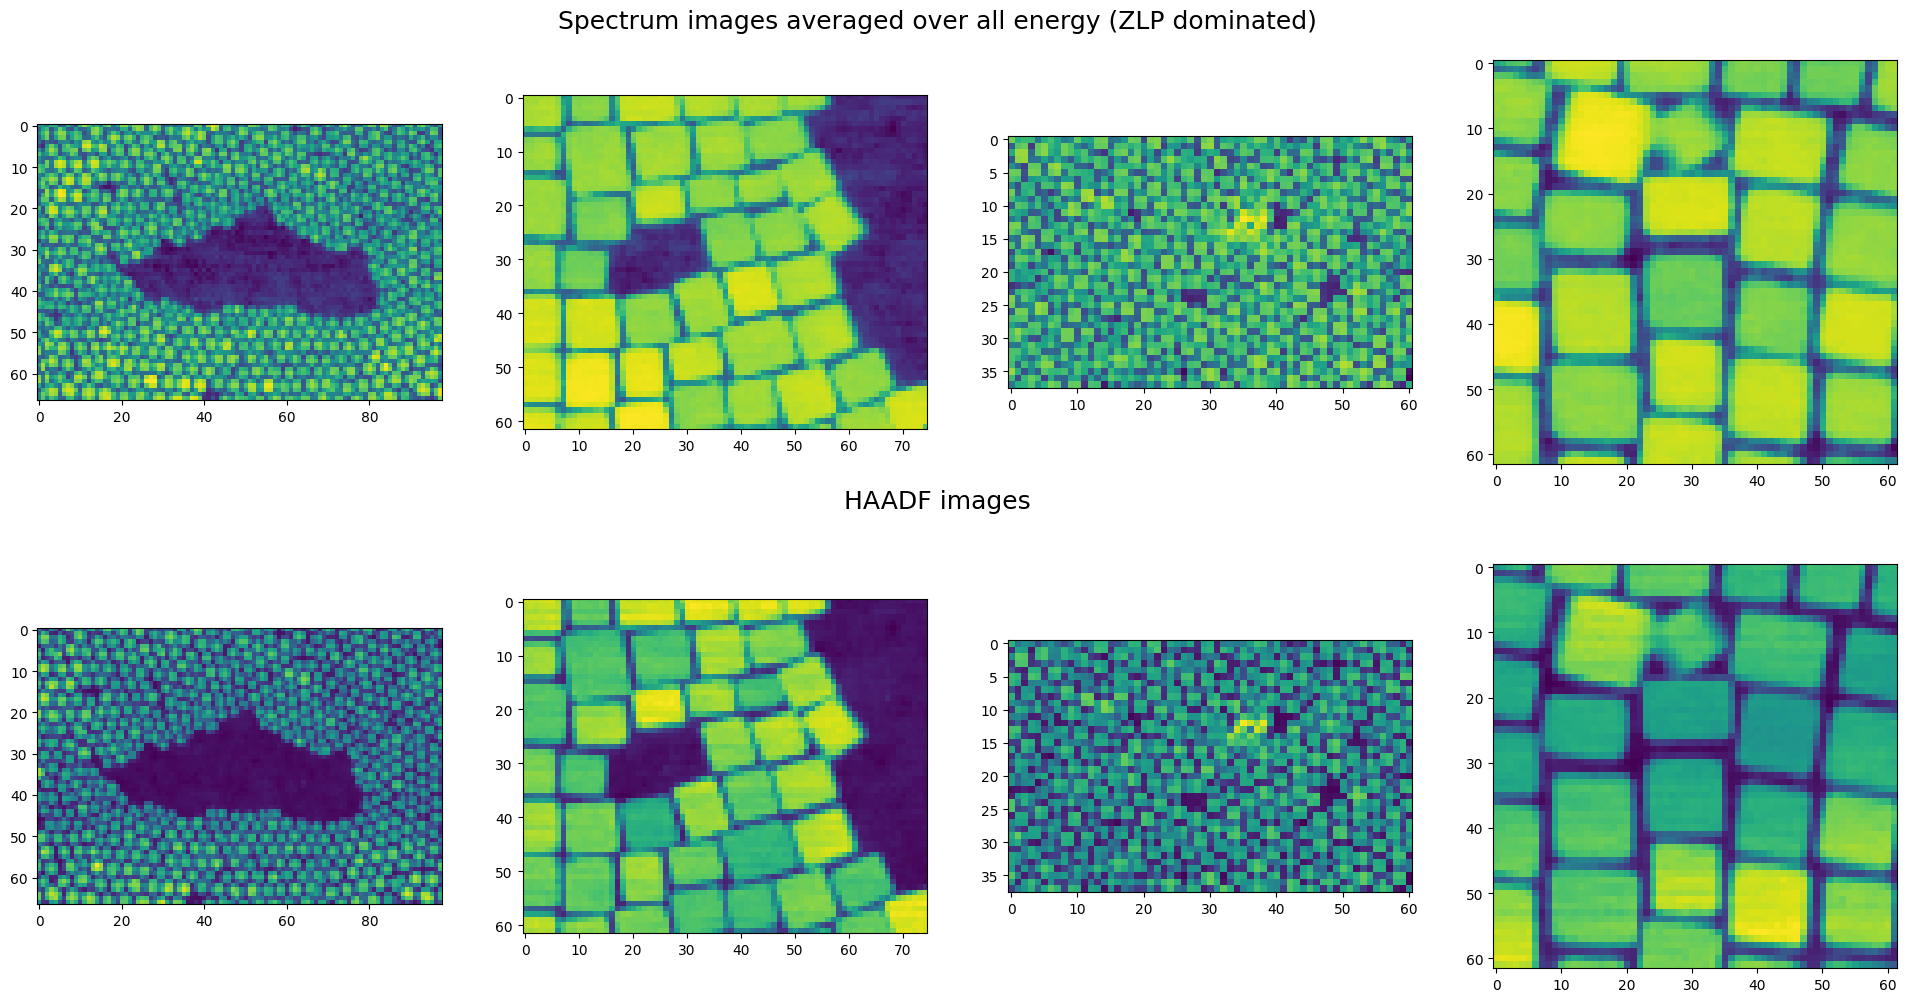

In [6]:
# Let's show the similarity between the structural image by ZLP contrast (since it dominates the spectrum) and the structure by HAADF:

# structure by "integrating" (really just averaging) entire spectra
f,a = plt.subplots(2,4,figsize=(24,12))

plt.gcf().text(0.5, 0.9, "Spectrum images averaged over all energy (ZLP dominated)", fontsize=18, ha = 'center')

a[0,0].imshow(np.mean(Datasets[0]['SI'][:,:,:],axis=2), cmap = 'viridis_r')
a[0,1].imshow(np.mean(Datasets[1]['SI'][:,:,:],axis=2), cmap = 'viridis_r')
a[0,2].imshow(np.mean(Datasets[2]['SI'][:,:,:],axis=2), cmap = 'viridis_r')
a[0,3].imshow(np.mean(Datasets[3]['SI'][:,:,:],axis=2), cmap = 'viridis_r')


# Structure by HAADF detector (normally considered the structural data)
plt.gcf().text(0.5, 0.5, "HAADF images", fontsize=18, ha = 'center')
a[1,0].imshow(Datasets[0]['HAADF'])
a[1,1].imshow(Datasets[1]['HAADF'])
a[1,2].imshow(Datasets[2]['HAADF'])
a[1,3].imshow(Datasets[3]['HAADF'])

Check specific spectral windows if desired:

(1815, 3097)

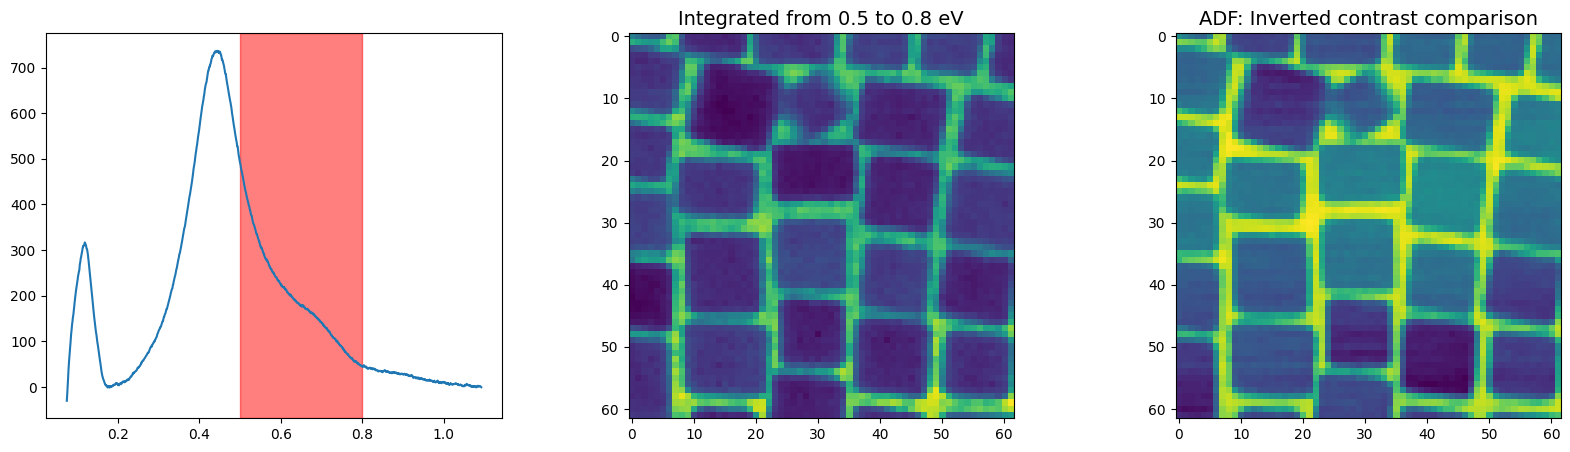

In [7]:
x1, x2 = 0.5, 0.8  # in eV

e1, e2 = (np.abs(Datasets[3]['ENB']-x1)).argmin(), (np.abs(Datasets[3]['ENB']-x2)).argmin()
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].plot(Datasets[3]['ENB'],np.mean(Datasets[3]['SINB'][:,:,:],axis=(0,1)))
ax[0].axvspan(x1,x2, color = 'r', alpha = 0.5)
ax[1].imshow(np.mean(Datasets[3]['SINB'][:,:,e1:e2],axis=2))
ax[1].set_title('Integrated from {} to {} eV'.format(x1,x2), fontsize = 14)
ax[2].imshow(Datasets[3]['HAADF'], cmap = 'viridis_r')
ax[2].set_title('ADF: Inverted contrast comparison', fontsize = 14)

e1,e2

Display HAADF with scalebar

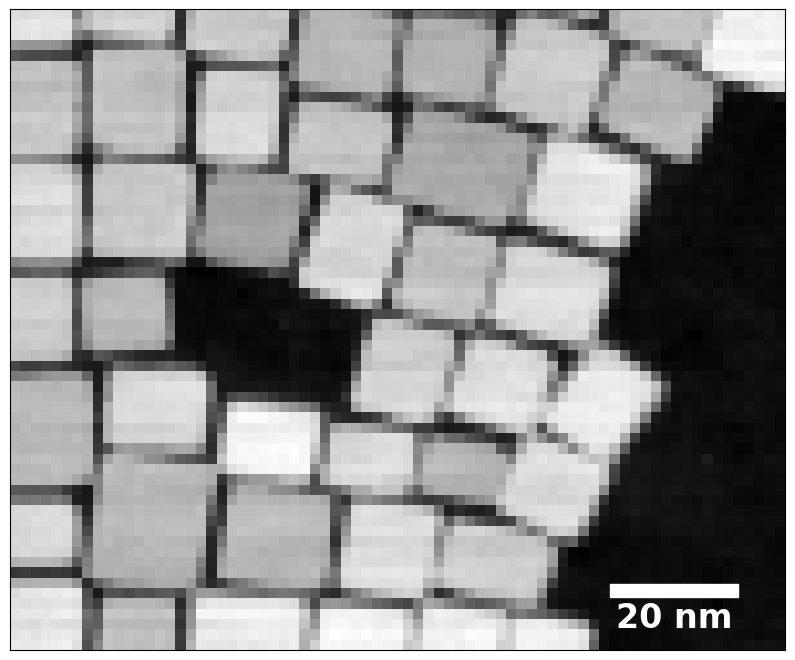

In [8]:
img   = np.copy(Datasets[1]['HAADF'])
scale = Datasets[1]['px_size_nm']
scalebarlength = 20      # nm units

# Positioning
xpos = 0.85
ypos = 0.075

SB = scalebarlength/scale
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(img, origin = 'lower', cmap ='gray')

xx = xpos*img.shape[1] - SB/2
yy = ypos*img.shape[0]

r1 = patches.Rectangle((xx, yy), SB, 1.25, color = 'w')
ax.add_patch(r1)
ax.annotate("{} nm".format(scalebarlength), (xx+SB/2, yy-3),
            color = 'w', weight = 'bold', fontsize = 24,
            ha = 'center')

plt.setp(ax, xticks=[], yticks=[]);

# Standard NMF extraction

In [9]:
from sklearn.decomposition import NMF

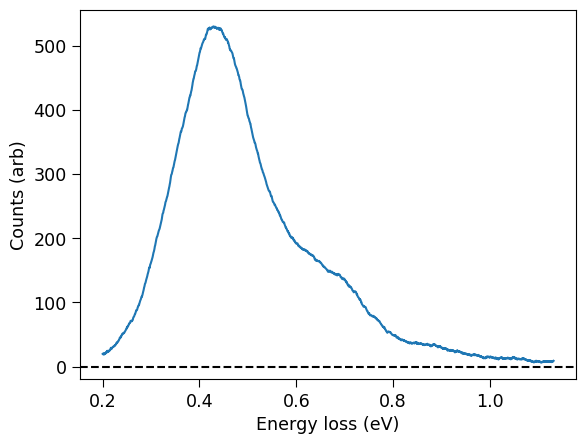

In [10]:
dset = 1

data = Datasets[dset]['SINB']
energy_axis_ = Datasets[dset]['ENB']

data_XY = (data.shape[0],data.shape[1])
data_flat = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2]))

cutoff_energy = 0.2 # cut energies lower than this-- removes effect of silicon nitride phonons
idx = (np.abs(energy_axis_-cutoff_energy)).argmin()
energy_axis = energy_axis_[idx:]

fsize = 14
plt.figure()
SIdecon=np.copy(data_flat[:,idx:])
SIdecon[np.where(SIdecon<0)]=0
plt.plot(energy_axis,np.mean(SIdecon[:,:],axis=(0)))
plt.axhline(0,color='k',ls='--')
plt.xlabel('Energy loss (eV)', fontsize=fsize*0.9)
plt.ylabel('Counts (arb)', fontsize = fsize*0.9)
plt.tick_params(labelsize = fsize*0.9, size = 6)

Text(0, 0.5, 'Counts')

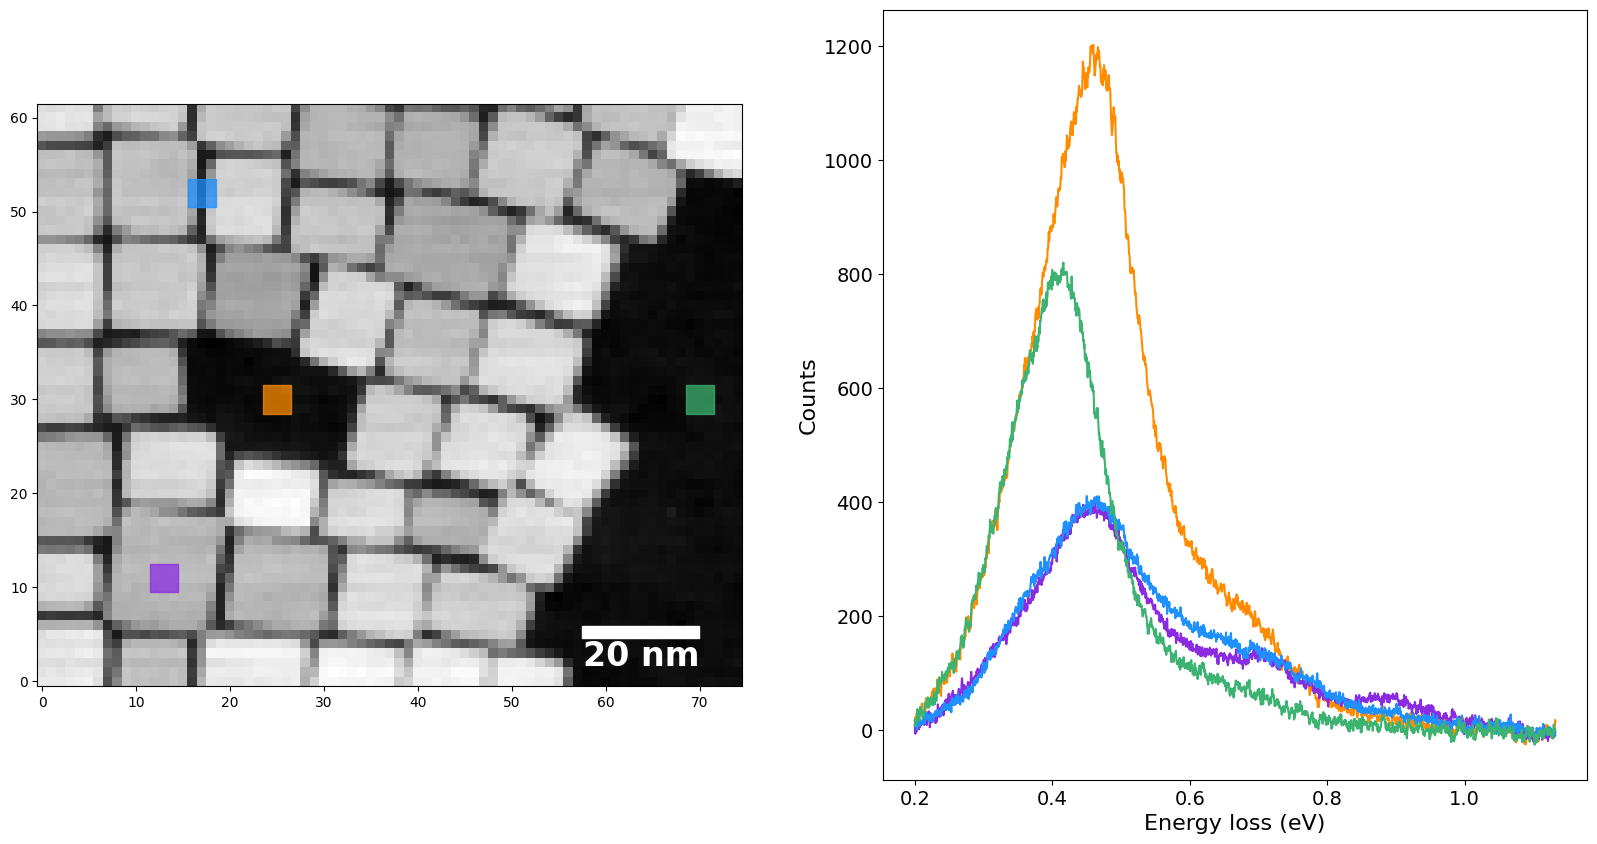

In [11]:
# Display selected spectra at particular positions (or small ROIs to help average out the signal)

img   = np.copy(Datasets[dset]['HAADF'])
scale = Datasets[1]['px_size_nm']

scalebarlength = 20      # nm units

# Positioning
xpos = 0.85
ypos = 0.075

SB = scalebarlength/scale
fig,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].imshow(img, origin = 'lower', cmap ='gray')

xx = xpos*img.shape[1] - SB/2
yy = ypos*img.shape[0]

r1 = patches.Rectangle((xx, yy), SB, 1.25, color = 'w')
ax[0].add_patch(r1)
ax[0].annotate("{} nm".format(scalebarlength), (xx+SB/2, yy-3),
            color = 'w', weight = 'bold', fontsize = 24,
            ha = 'center')

winsize = 3

# select centers of ROIs of interest
ROI1 = [25,30]
ROI2 = [13,11]
ROI3 = [17,52]
ROI4 = [70,30]
ROIs = np.array([ROI1, ROI2, ROI3, ROI4])

colors = ['darkorange', 'blueviolet', 'dodgerblue', 'mediumseagreen']
for k in range(len(ROIs)):
  ax[0].add_patch(patches.Rectangle((ROIs[k,0]-winsize/2, ROIs[k,1]-winsize/2), winsize, winsize, color = colors[k], alpha = 0.75))
  ax[1].plot(energy_axis, np.mean(data[ROIs[k,1]-winsize:ROIs[k,1]+winsize, ROIs[k,0]-winsize:ROIs[k,0]+winsize, idx:],axis = (0,1)), color = colors[k])

ax[1].tick_params(labelsize = 14)
ax[1].set_xlabel('Energy loss (eV)', fontsize = 16)
ax[1].set_ylabel('Counts', fontsize = 16)

Text(0.5, 1.0, 'Scree plot')

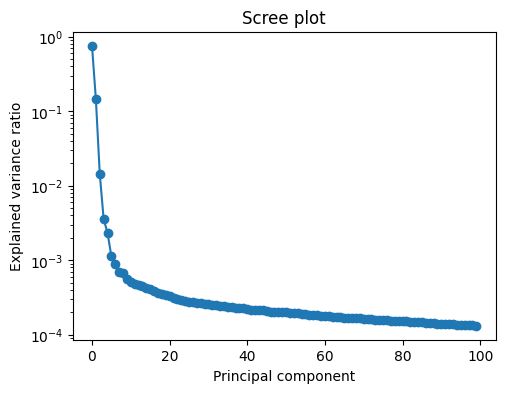

In [12]:
fig= plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0,0])

pca = PCA()
pca.fit(data_flat[:,idx:])
explained_var = pca.explained_variance_ratio_

ax1.plot(explained_var[0:100], 'o-')
ax1.semilogy()
ax1.set_xlabel('Principal component')
ax1.set_ylabel('Explained variance ratio');
ax1.set_title('Scree plot')

In [13]:
N=4

model=NMF(n_components=N)
NMFIm=model.fit_transform(SIdecon[:,:])
NMFSpec=model.components_
NMFIm=NMFIm.reshape(data_XY+(N,)).transpose(2,0,1)

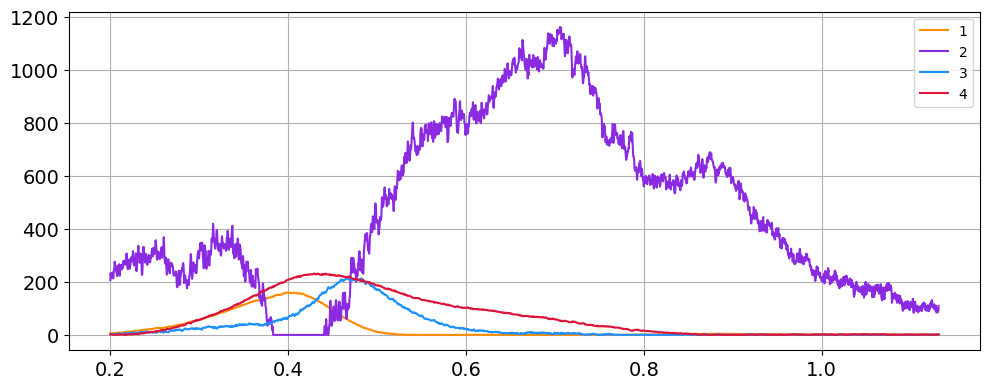

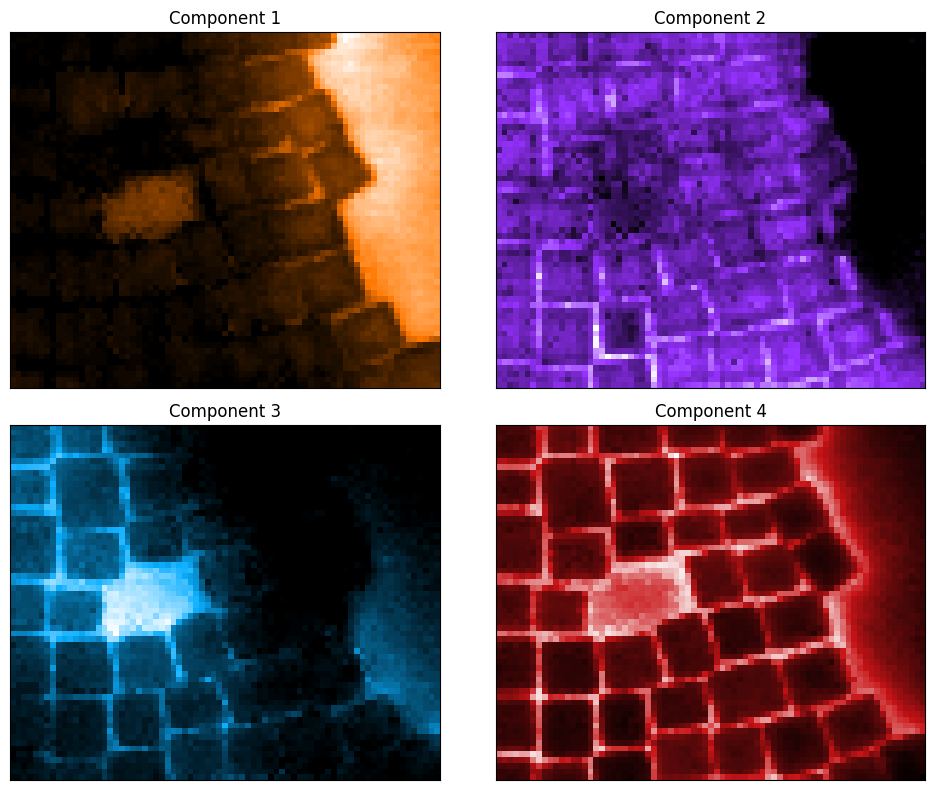

In [14]:
colors=['DarkOrange','BlueViolet','DodgerBlue','Crimson','MediumSeaGreen','Tan','HotPink','Yellow','Black']
cmaps=[bOw,bPw,bBw,bRw,bGw,bBrw,bPiw,bYw]

rows = int(np.ceil(float(N)/3))
cols = int(np.ceil(float(N)/rows))

fig1,ax1 = plt.subplots(figsize = (10,4))

for i in range(N):
    ax1.plot(energy_axis,NMFSpec[i], color = colors.pop(0), label = i+1)
    ax1.grid(True)
    ax1.tick_params(labelsize=14)
    ax1.legend()
plt.tight_layout()

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (5*cols, 4*(1+rows//2)))

for i in range(N):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(NMFIm[i],cmap = cmaps.pop(0))
#     ax2.imshow(NMFIm[i],cmap = 'magma')
    ax2.set_title('Component ' + str(i+1))
    plt.setp([ax2],xticks=[], yticks=[])
plt.tight_layout()

# Now the encoder-decoders!

In [15]:
!pip install pyroved

import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, MeanShift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl size=11684778 sha256=b8b9af492e2b4535953803fd54fc2f497bfecc5612c0a7c74d732a6b3b77e312
  Stored in directory: /root/.cache/pip/wheels/38/c6/49/eaba6d234887d98d9c85185e2a90bd7bb77934e85eefaf317e
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib

* <font size = 5> Image patches: </font>

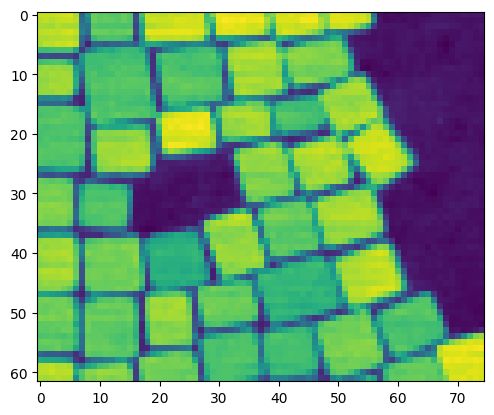

In [16]:
dset = 1
plt.imshow(Datasets[dset]['HAADF'])

## im2spec

In [17]:
dset = 1

window_size = 16

image = Datasets[dset]['HAADF']
hdata = Datasets[dset]['SINB']
coordinates_ = get_coord_grid(image, step = 1, return_dict=False)
patches, spectra_, coords = extract_patches_and_spectra(hdata, image, coordinates = coordinates_, window_size = window_size, avg_pool = 2)

<ipython-input-3-9e9f6dd19840>:188: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  spectra = torch.tensor(spectra).unsqueeze(1)


* There is a substrate peak that we probably don't want (silicon nitride phonon @ 180 meV)
* Also, we really don't need so many energy channels. 1024 is plenty, let's rescale to this. (probably 512 or even 128 is fine too! Try it!)

In [18]:
new_spectral_length = 1024
truncate = 200

spectra = spectra_[:,truncate:]   # cut a substrate peak out (silicon nitride phonon @ 180 meV)
spectra = interpolate_spectra(spectra, new_spectral_length)  # divisble by 16 (?)  #

spectra.shape

(2820, 1024)

In [19]:
features = patches
targets  = spectra
indices  = coords
full_img = image

print(features.shape, targets.shape)

(2820, 16, 16) (2820, 1024)


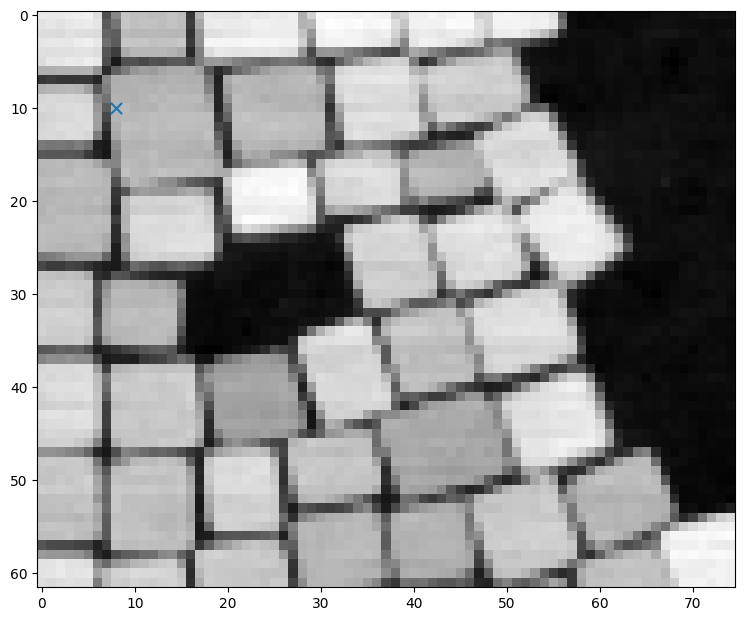

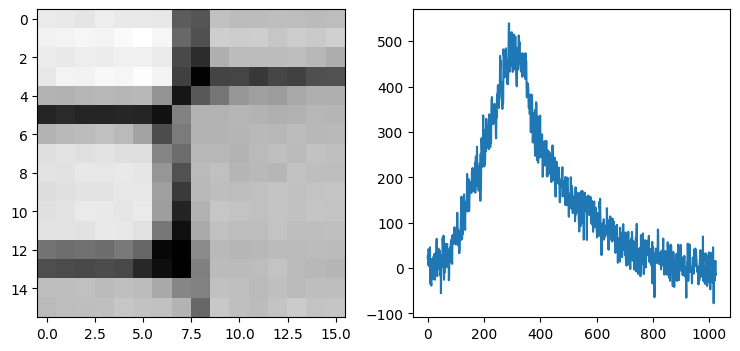

In [20]:
k = 120

plt.figure(figsize=(9, 9))
plt.imshow(full_img, cmap='gray')
plt.scatter(indices[k,1], indices[k,0], marker='x', s=64)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(features[k], cmap='gray')
ax2.plot(targets[k])  # here we disregard the actual x-axis values

Here we normalize the data, add explicitly a channel dimension, and then split into train and test sets:

In [21]:
norm_ = lambda x: torch.from_numpy((x - x.min()) / (x.max() - x.min())).float()
features, targets = norm_(features[:, None]), norm_(targets[:, None])
(features, features_test, targets, targets_test,
 indices, indices_test) = train_test_split(
    features, targets, indices, test_size=0.15, shuffle=True, random_state=1)

Initialize a dataloader:

In [22]:
train_loader = pv.utils.init_dataloader(features, targets)

Initialize and train an *im2spec* model:

In [23]:
# Specify input and output dimensions
in_dim = (16, 16)  # images height and width
out_dim = (1024,)  # length of spectra
# out_dim = (targets.shape[1],)  # length of spectra
# Initialize model
ved = pv.models.VED(in_dim, out_dim, sampler_d="bernoulli", latent_dim = 2)

# Initialize trainer
trainer = pv.trainers.SVItrainer(ved)

# Train for n epochs
for _ in range(100):
    trainer.step(train_loader, scale_factor=4)
    trainer.print_statistics()

/usr/local/lib/python3.10/dist-packages/pyroved/nets/conv.py:173: UserWarning: 'bilinear' mode is not supported for 1D and 3D; switching to 'nearest' mode
  warn(warn_msg, category=UserWarning)


Epoch: 1 Training loss: 559.2970
Epoch: 2 Training loss: 457.8166
Epoch: 3 Training loss: 454.8890
Epoch: 4 Training loss: 453.7876
Epoch: 5 Training loss: 453.0548
Epoch: 6 Training loss: 452.5800
Epoch: 7 Training loss: 452.3644
Epoch: 8 Training loss: 452.3822
Epoch: 9 Training loss: 452.1674
Epoch: 10 Training loss: 452.2065
Epoch: 11 Training loss: 452.0863
Epoch: 12 Training loss: 451.3340
Epoch: 13 Training loss: 450.0999
Epoch: 14 Training loss: 449.4541
Epoch: 15 Training loss: 449.0565
Epoch: 16 Training loss: 448.4288
Epoch: 17 Training loss: 448.2488
Epoch: 18 Training loss: 448.1473
Epoch: 19 Training loss: 447.9823
Epoch: 20 Training loss: 447.7334
Epoch: 21 Training loss: 447.7928
Epoch: 22 Training loss: 447.7415
Epoch: 23 Training loss: 447.6134
Epoch: 24 Training loss: 447.7073
Epoch: 25 Training loss: 447.5222
Epoch: 26 Training loss: 447.4579
Epoch: 27 Training loss: 447.4344
Epoch: 28 Training loss: 447.2971
Epoch: 29 Training loss: 447.3249
Epoch: 30 Training loss

Plot the learned latent manifold (spectral domain):

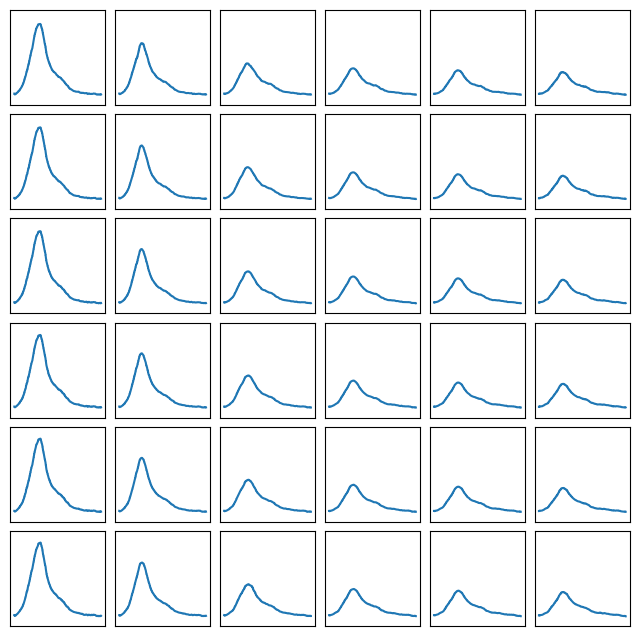

In [24]:
ved.manifold2d(d=6, ylim=[0., .8], cmap='viridis');

Now let's encode *test* images into the latent space:

Text(0, 0.5, '$z_2$')

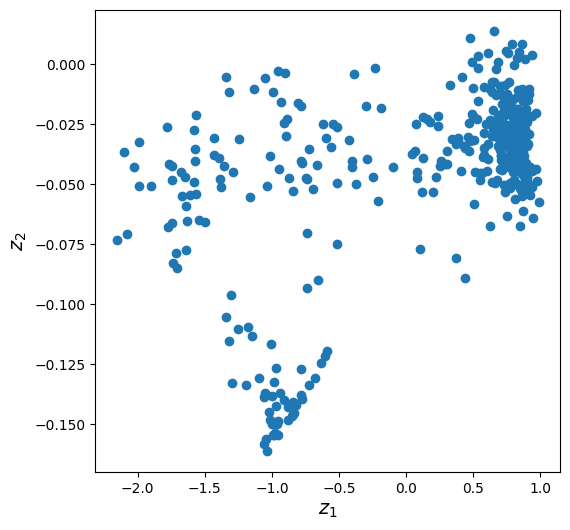

In [25]:
z, _ = ved.encode(features_test)

plt.figure(figsize=(6, 6))
plt.scatter(z[:, 1], z[:, 0])
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)

We can see that the encoded features form ~3-4 clusters. We can separate them using *e.g* a mean-shift clustering method:

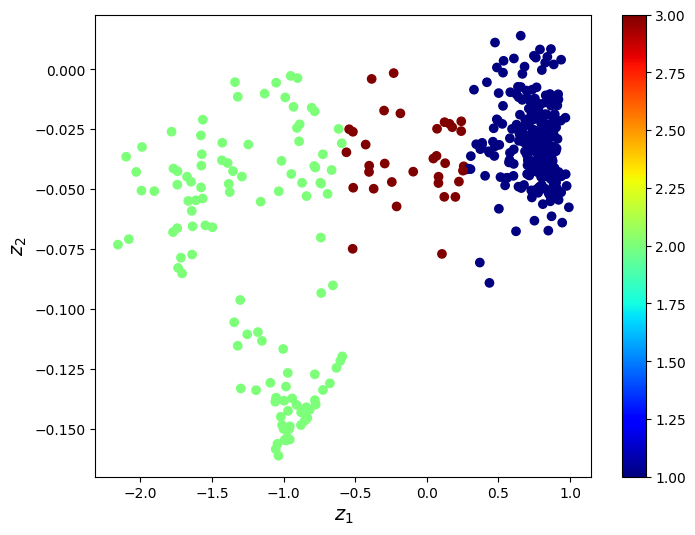

In [26]:
clustering = MeanShift(bandwidth=0.50).fit(z)
labels = torch.from_numpy(clustering.labels_) + 1

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 1], z[:, 0], c=labels, cmap='jet')
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)
plt.colorbar();

Next, we decode spectra (using *im2spec*'s trained decoder) corresponding to the center of the mass for the four main clusters...

<ipython-input-27-6c7185b72352>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet', len(labels.unique()))


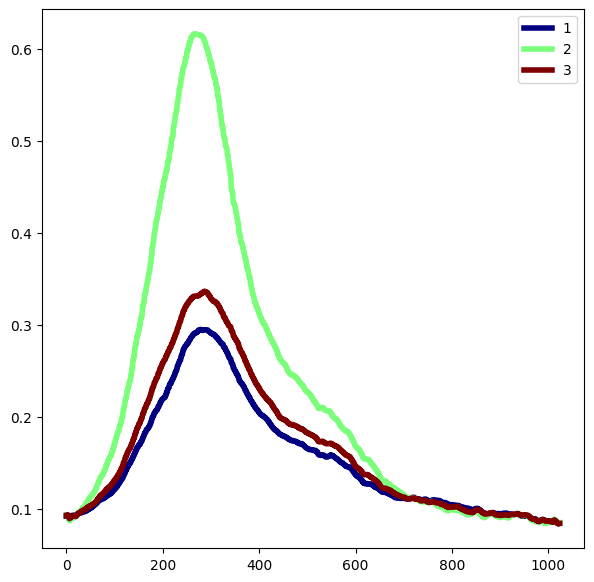

In [27]:
cmap = mpl.cm.get_cmap('jet', len(labels.unique()))
_, ax = plt.subplots(figsize=(7, 7))
for i in labels.unique():
    zc = torch.mean((z[labels==i]), 0)
    xc = ved.decode(zc)
    ax.plot(xc.squeeze(), c=cmap(i.item()-1), lw=4, label=i.item())
plt.legend()

... and see which local structures these spectra are associated with:

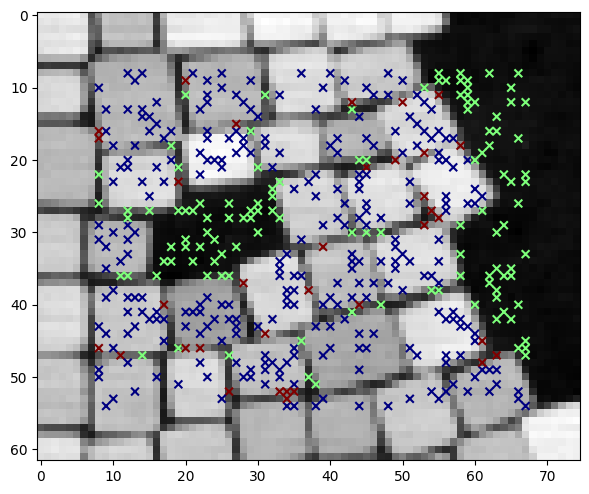

In [28]:
plt.figure(figsize=(7, 7))
plt.imshow(full_img, cmap='gray')
plt.scatter(indices_test[:, 1], indices_test[:, 0], s=32,
            marker='x', c=labels, cmap='jet');

Clearly, the first clustered component corresponds to particles, the second one to the gaps between particles, the third one to the hole in the array, and the fourth one to the outside region. Comparing these results with the manual inspection of spectra confirms that the trained *im2spec* model was able to correctly correlate particles geometry with spectroscopic shapes.

Now let's make an *image* $\rightarrow$ *spectrum* prediction on the test data:

In [29]:
pred_mean, pred_sd = ved.predict(features_test)

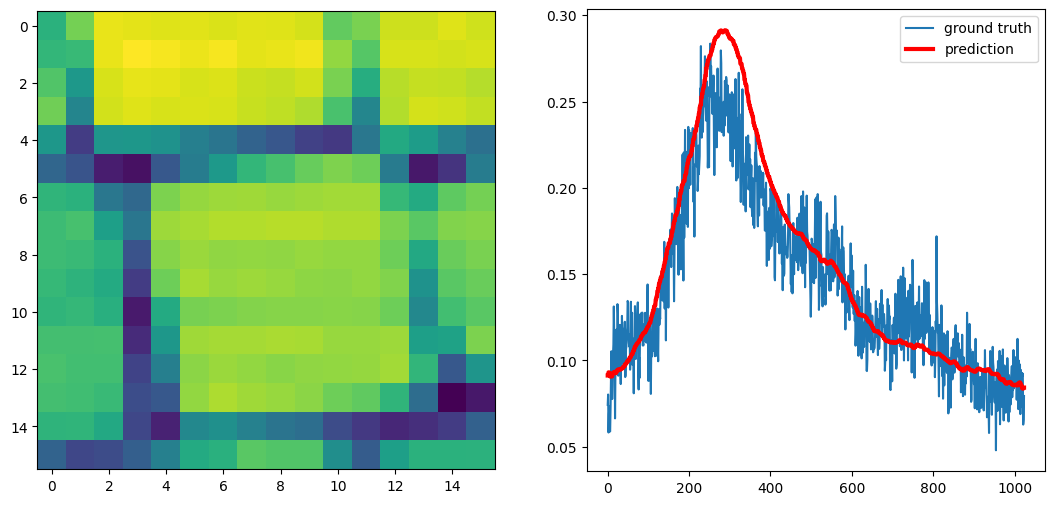

In [30]:
k = 10

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.imshow(features_test[k].squeeze())
ax2.plot(targets_test[k].squeeze(), label="ground truth", zorder=0)
ax2.plot(pred_mean[k].squeeze(), c='r', lw=3, label="prediction", zorder=1)
ax2.legend()

Depends on:

1. window size
2. spetral binning (# of pixels in a spectrum)
3. data preprocessing or even spectral band selection
4. number of latent dimensions
5. ???

Play with these!